# First, we need to define our agents.
*     Agents are in a fully populated, non-torodial n x m grid.
*     Every timestep, agents will update probabilities of language spoken as per Prochazka et al. (2017)

In [5]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
from mesa.space import SingleGrid
from scipy.spatial import distance
import numpy as np
import math
import random

class LanguageAgent(Agent):
    def __init__(self, model, unique_id, initial_population, initial_prob_v):
        super().__init__(unique_id, model)
        self.population = initial_population
        self.probability = np.array(initial_prob_v)
        self.next_probability = np.array(self.probability, copy=True)
        self.diffusion = self.model.diffusion
        
    def calculate_contribution(self, other):
        '''
        args:
            other(LanguageAgent): an adjacent or otherwise relevant other LanguageAgent
        '''
        return ((other.population * other.probability)/(4*np.pi*self.diffusion)) * np.exp(-np.square(np.abs(distance.euclidean(self.pos, other.pos)))/(4*self.diffusion))
    
    def step(self):
        f = np.zeros(len(self.probability))
        for neighbor in self.model.grid.iter_neighbors(self.pos, moore=True):
            f += self.calculate_contribution(neighbor)
        
        self.next_probability = ((self.population * self.probability) + f) / (np.sum(f) + self.population)
        
        
    def advance(self):
        self.probability, self.next_probability = self.next_probability, self.probability
        

class LanguageModel(Model): 
    def __init__(self, width, height, diffusivity):
        self.num_agents = width*height
        self.grid = SingleGrid(width, height, False)
        self.schedule = SimultaneousActivation(self)
        self.diffusion = np.array(diffusivity)
        
        num_agents = 0
        for x in range(width):
            for y in range(height):
                num_agents += 1
                # Create agents, add them to scheduler
                a = LanguageAgent(self, num_agents, 1000 + 500 * random.random(), [random.random(), random.random()])
                self.schedule.add(a)
            
                #add the agent at position (x,y)
                self.grid.place_agent(a, (x,y))
        
        self.datacollector = DataCollector(
            model_reporters={},
            agent_reporters={"num_speakers": lambda a: a.population * a.probability})

                
    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()
        for cell in model.grid.coord_iter():
            cell_content, x, y = cell
            #cheap way of adding changing population dynamics for now
            cell_content.population = cell_content.population * 1 + random.random()/12
        

Now that the model and agents are described, a demonstration is ran. This assumes equal diffusion, and random positive population growth.

diffusivities: [ 0.5  0.5]


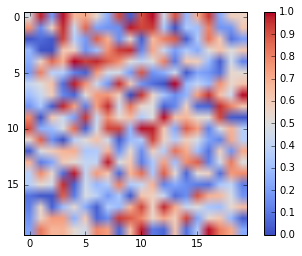

step: 0


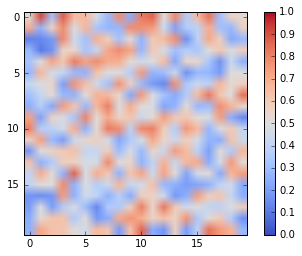

step: 1


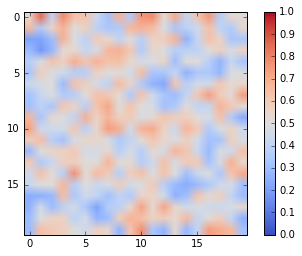

step: 2


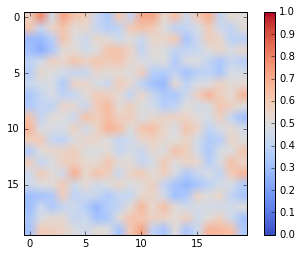

step: 3


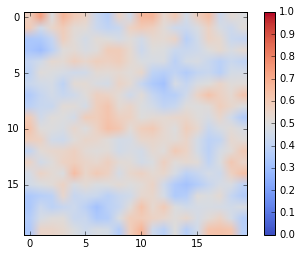

step: 4


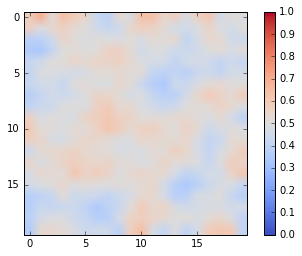

step: 5


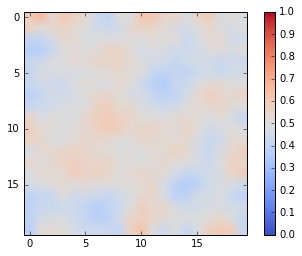

step: 6


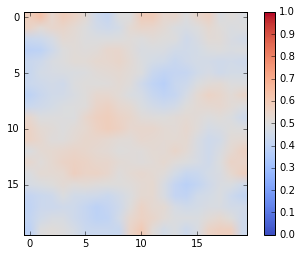

step: 7


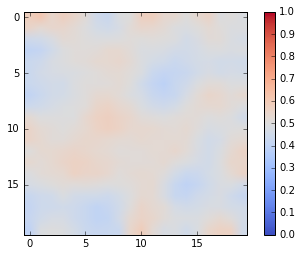

step: 8


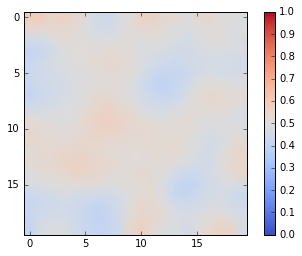

step: 9


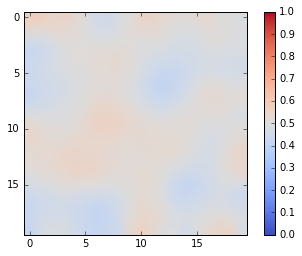

step: 10


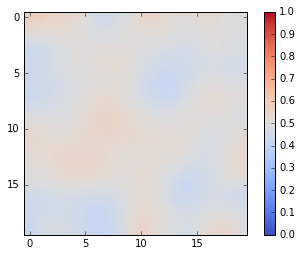

step: 11


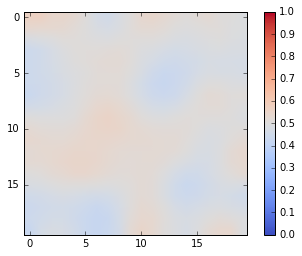

step: 12


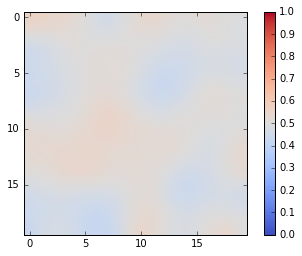

step: 13


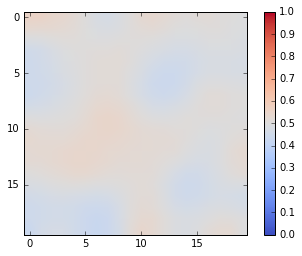

step: 14


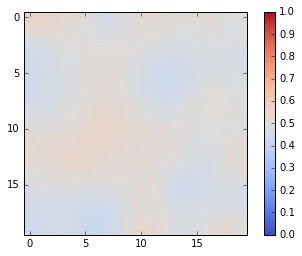

step: 15


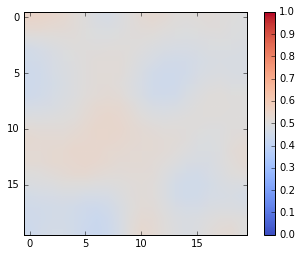

step: 16


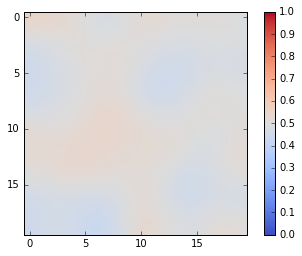

step: 17


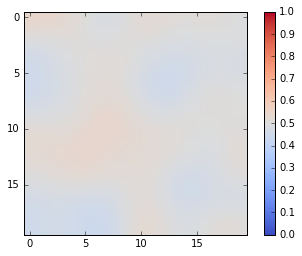

step: 18


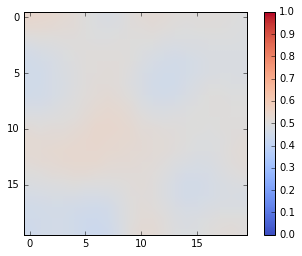

step: 19


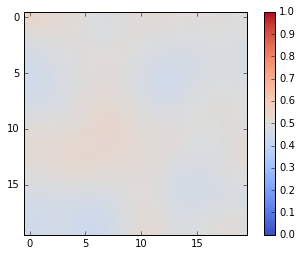

step: 20


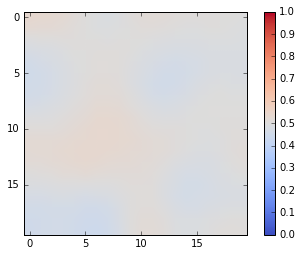

step: 21


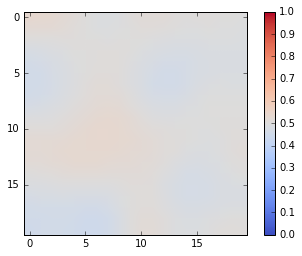

step: 22


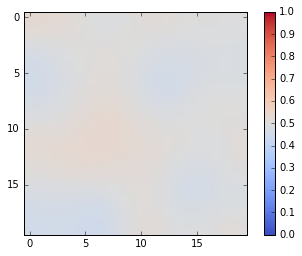

step: 23


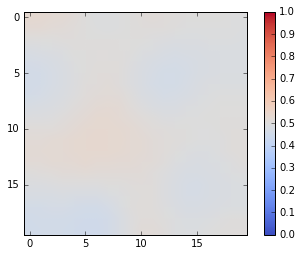

step: 24


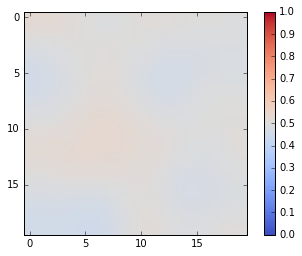

step: 25


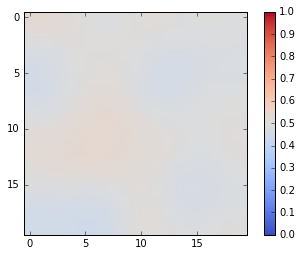

step: 26


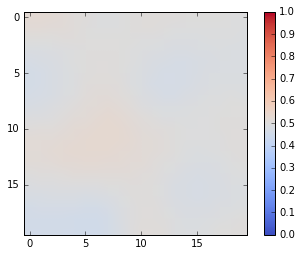

step: 27


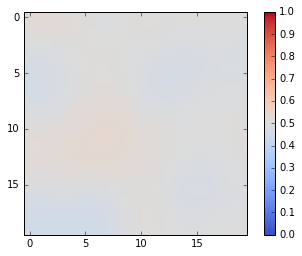

step: 28


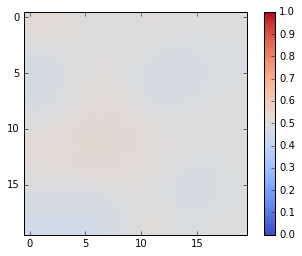

step: 29


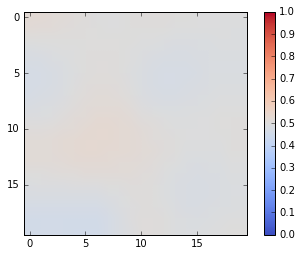

In [22]:
import matplotlib.pyplot as plt

#LanguageModel( width, height, [diffusivity list])
model = LanguageModel(20,20, [.5, .5])

print("diffusivities: " + str(model.diffusion))

#generate heatmap graph of final probabilities.
agent_counts = np.empty((20,20))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_counts[x][y] = cell_content.probability[0]
plt.imshow(agent_counts, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
plt.show()


#run model for 30 years
for i in range(30):
    print("step: " + str(i) )
    model.step()  
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_counts[x][y] = cell_content.probability[0]
    plt.imshow(agent_counts, cmap='coolwarm', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()



  